
讀取資料

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/守燦_碩士論文實作/假新聞3/CCPD_EDA.csv')

Mounted at /content/drive


自然語言處理與Word2Vec模型建立

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


讀取資料集完成


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


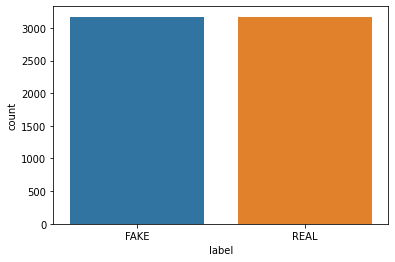

                                               title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text  label  
0  Daniel Greenfield, a Shillman Journalism Fello...      1  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...      1  
2  U.S. Secretary of State John F. Kerry said Mon...      0  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...      1  
4  It's primary day in New York and front-runners...      0  
0    Daniel Greenfield  a Shillman Journalism Fello...
1    Google Pinterest Digg Linkedin Reddit Stumbleu...
2    U S  Secretary of State John F  Kerry said Mon...
3      Kaydee King   KaydeeKing  November 9  2016 T...
4    It s primary day in New York and front runners...
Name: text, dtyp

In [2]:
#套件載入
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Dense
from gensim.models.keyedvectors import KeyedVectors
#讀取資料集
#data=pd.read_csv('news1_eda.csv')
print("讀取資料集完成")
#觀查label欄位資料平衡的狀況
sns.countplot(data['label'])
plt.show()
#label欄位資料轉換(fake:1,true:0)
mapping={'FAKE':1,'REAL':0}
data=data.replace({'label': mapping})
print(data.head())
#自然語言處理-字詞正則化
def irrelevant(text):
    return re.sub('[^a-zA-Z0-9]',' ',text)
data['text']=data['text'].apply(irrelevant)
print(data['text'].head())
print("字詞正則化-完成")
#自然語言處理-轉換所有字母為小寫
def lowering(text):
    return str(text).lower()
data['text']=data['text'].apply(lowering)
print(data['text'].head())
print("轉換所有字母為小寫-完成")
#自然語言處理-斷詞
def token(text):
    return word_tokenize(text)
data['text']=data['text'].apply(token)
print(data['text'].head())
print('斷詞-完成')
#自然語言處理-移除停用字
stopwords=set(stopwords.words('english'))
def stop_words(text):
    return [item for item in text if item not in stopwords]
data['text']=data['text'].apply(stop_words)
print(data['text'].head())
print("移除停用字-完成")
#定義X與Y
y=data["label"] #Fake或True
x=data['text'] #內文
#切割資料集
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
print("切割資料集-完成")
#自然語言處理-標註向量與填充文字(Tokenization,Padding):用向量表示每個詞彙，以利後續GloVe模型建立。
max_len=300
tokenizer=text.Tokenizer(num_words=max_len) #標註內文的限制為內文最多300字，若少於300字則進行填充並截斷長字
tokenizer.fit_on_texts(x_train) #將內文所有詞彙的向量映射保存在Glove分詞器的word_index屬性中
tokenized_train=tokenizer.texts_to_sequences(x_train) #標註訓練集內文
x_train=sequence.pad_sequences(tokenized_train,maxlen=max_len) #填充訓練集內文
tokenized_test=tokenizer.texts_to_sequences(x_test) #標註測試集內文
x_test=sequence.pad_sequences(tokenized_test,maxlen=max_len) #填充測試集內文
print("標註與填充文字-完成")
#建立Word2Vec預訓練模型
path="/content/drive/MyDrive/守燦_碩士論文實作/預訓練資源檔/GoogleNews-vectors-negative300.bin" #Word2Vec預訓練模型的檔案
word2vec=KeyedVectors.load_word2vec_format(path,binary=True,limit=500000) 
embedding_index={}
word_index=tokenizer.word_index
for word, vector in zip(word2vec.vocab,word2vec.vectors):
      coefs=np.asarray(vector,dtype='float32')
      embedding_index[word]=coefs
vocab_size=len(tokenizer.word_index) + 1
embedding_matrix=np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector=embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
print("Embedding Matrix: \n",embedding_matrix)
print("Embedding Matrix size: ",embedding_matrix.shape)
print("建立Word2Vec預訓練模型-完成")

嵌入Word2Vec至BiLSTM模型訓練

In [3]:
#定義BiLSTM模型參數
batch_size=128
epochs=20
embed_size=100
#建立BiLSTM模型
model=Sequential()
model.add(Embedding(vocab_size,output_dim=300,weights=[embedding_matrix],input_length=300,trainable=False))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Bidirectional(LSTM(32,return_sequences=False)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())
print("BiLSTM模型建立-完成")
#訓練BiLSTM模型
history=model.fit(x_train,y_train,batch_size=batch_size,validation_data=(x_test,y_test),epochs=epochs)
print("BiLSTM模型訓練-完成")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          17370900  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17,600,053
Trainable params: 229,153
Non-t

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


35/35 [==============================] - 14s 105ms/step - loss: 0.6398 - accuracy: 0.6538 - val_loss: 0.5672 - val_accuracy: 0.7759
Epoch 2/20
35/35 [==============================] - 2s 60ms/step - loss: 0.4995 - accuracy: 0.7963 - val_loss: 0.4436 - val_accuracy: 0.8064
Epoch 3/20
35/35 [==============================] - 3s 96ms/step - loss: 0.3970 - accuracy: 0.8340 - val_loss: 0.3684 - val_accuracy: 0.8496
Epoch 4/20
35/35 [==============================] - 2s 66ms/step - loss: 0.3680 - accuracy: 0.8509 - val_loss: 0.3499 - val_accuracy: 0.8417
Epoch 5/20
35/35 [==============================] - 2s 61ms/step - loss: 0.3223 - accuracy: 0.8640 - val_loss: 0.3598 - val_accuracy: 0.8501
Epoch 6/20
35/35 [==============================] - 2s 62ms/step - loss: 0.3166 - accuracy: 0.8656 - val_loss: 0.4197 - val_accuracy: 0.8059
Epoch 7/20
35/35 [==============================] - 2s 60ms/step - loss: 0.3700 - accuracy: 0.8376 - val_loss: 0.3239 - val_accuracy: 0.8485
Epoch 8/20
35/35 [====

In [4]:
#準確度評估
print("訓練集的模型準確度: " ,model.evaluate(x_train,y_train)[1]*100 , "%")
print("測試集的模型準確度: " ,model.evaluate(x_test,y_test)[1]*100 , "%")

139/139 [==============================] - 3s 18ms/step - loss: 0.1660 - accuracy: 0.9362
訓練集的模型準確度:  93.6174988746643 %
60/60 [==============================] - 1s 18ms/step - loss: 0.2934 - accuracy: 0.8806
測試集的模型準確度:  88.05891871452332 %


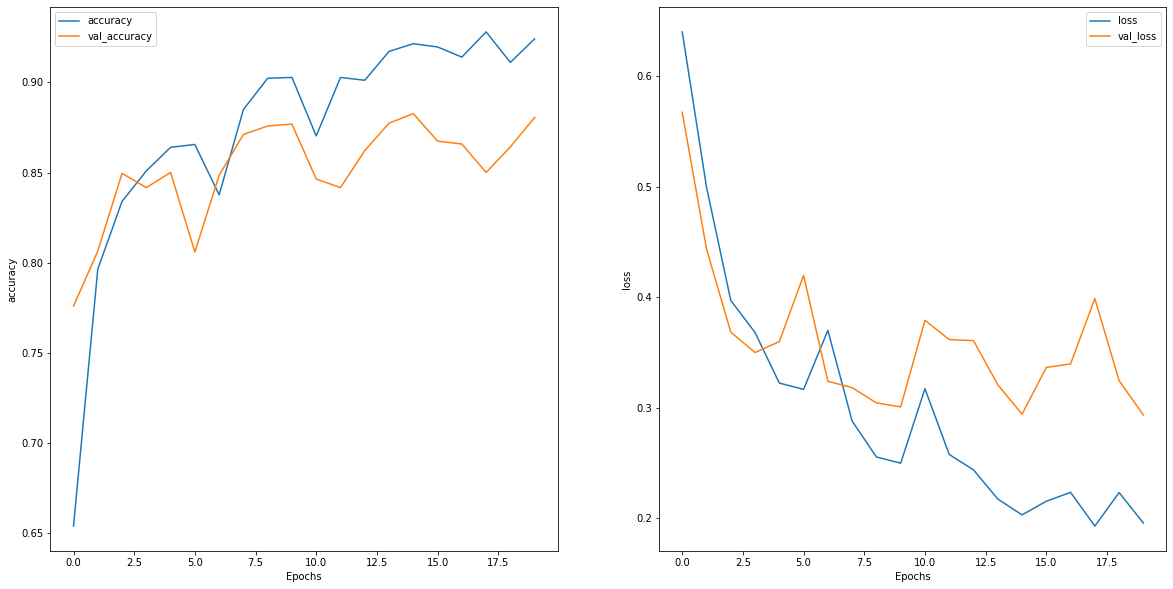

In [5]:
#繪製準確度變化與損失函數圖
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric],'')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric,'val_'+metric])
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot_graphs(history,'accuracy')
plt.subplot(1,2,2)
plot_graphs(history,'loss')

模型績效評估(準確度、損失函數、分類報告、混淆矩陣)

In [6]:
#分類報告
prediction=(model.predict(x_test)>0.5).astype("int32")
print("分類報告: ",classification_report(y_test,prediction,digits=4))

分類報告:                precision    recall  f1-score   support

           0     0.8731    0.8957    0.8842       968
           1     0.8888    0.8650    0.8767       933

    accuracy                         0.8806      1901
   macro avg     0.8809    0.8803    0.8805      1901
weighted avg     0.8808    0.8806    0.8805      1901



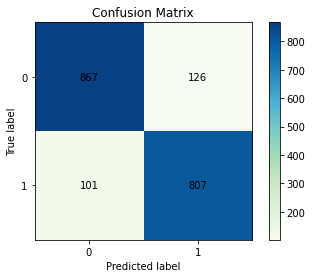

In [7]:
#繪製混淆矩陣
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.GnBu)
    plt.colorbar()
    for x in range(len(confusion_mat)):
        for y in range(len(confusion_mat)):
            plt.annotate(confusion_mat[x, y], xy=(x, y),horizontalalignment='center',verticalalignment='center')
    plt.title('Confusion Matrix')    
    plt.ylabel('True label')         
    plt.xlabel('Predicted label')     
    tick_marks = np.arange(2)
    plt.xticks(tick_marks,tick_marks)
    plt.yticks(tick_marks,tick_marks)
    plt.show()
from sklearn import metrics
confusion_mat=metrics.confusion_matrix(y_test,prediction,labels=None,sample_weight=None)
plot_confusion_matrix(confusion_mat)